In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import h5py

import tensorflow as tf
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

from time import time
from icecream import ic

from msfm.utils import tfrecords, files, parameters
from msfm.fiducial_pipeline import FiducialPipeline
from msfm.utils.input_output import read_yaml

# v4

In [3]:
tfr_pattern = "/pscratch/sd/a/athomsen/DESY3/v5/linear_bias/tfrecords/fiducial/DESy3_fiducial_000.tfrecord"
conf = "/global/homes/a/athomsen/multiprobe-simulation-forward-model/configs/v5/linear_bias.yaml"
params = ["Om", "s8", "Aia", "n_Aia", "bg", "n_bg"]

In [1]:
fidu_pipe = FiducialPipeline(
    conf=conf,
    params=params,
    with_lensing=True,
    with_clustering=True,
    with_padding=True,
    apply_norm=False,
    shape_noise_scale=1.0,
    poisson_noise_scale=1.0,    
)

n_side = 512
n_pix = hp.nside2npix(n_side)

params = fidu_pipe.params
n_params = len(params)
n_maps = 2 * len(params) + 1 
n_noise = 3
data_vec_pix = fidu_pipe.data_vec_pix
n_z = fidu_pipe.n_z_metacal + fidu_pipe.n_z_maglim
n_z_metacal = fidu_pipe.n_z_metacal

NameError: name 'FiducialPipeline' is not defined

In [5]:
dset = fidu_pipe.get_dset(
    tfr_pattern=tfr_pattern,
    local_batch_size=1,
    n_noise=n_noise,
    n_readers=1,
    examples_shuffle_buffer=None,
    n_prefetch=0,
    is_eval=True,
)

23-10-17 08:20:20 fiducial_pip WAR   Evaluation mode is activated: the random seed is fixed, the shuffle arguments ignored, and the dataset is not repeated 
23-10-17 08:20:20 fiducial_pip INF   Interleaving with n_readers = 1 


/global/common/software/des/athomsen/dlss/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:2210: UserWarning: The `deterministic` argument has no effect unless the `num_parallel_calls` argument is specified.
  warnings.warn("The `deterministic` argument has no effect unless the "


23-10-17 08:20:21 fiducial_pip INF   Batching into 1 elements locally 
23-10-17 08:20:21 fiducial_pip WAR   Tracing _augmentations 
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
23-10-17 08:20:22 fiducial_pip INF   Running on the data_vectors.keys() = dict_keys(['kg_fiducial', 'dg_fiducial', 'kg_delta_O

In [6]:
for data_vector, index in dset.take(1):
    pass

print(data_vector.shape)
print(index)

f = np.zeros(n_pix)
f[data_vec_pix] = data_vector[0,:,0]
f = hp.reorder(f, n2r=True)

fs = np.zeros((n_pix, n_z))
fs[data_vec_pix] = data_vector[0]
for i in range(n_z):
    fs[:,i] = hp.reorder(fs[:,i], n2r=True)

(13, 464896, 8)
(<tf.Tensor: shape=(1,), dtype=int64, numpy=array([591])>, <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>)


In [7]:
# # downscale
# n_side = 128
# n_pix = hp.nside2npix(n_side)

# f = hp.ud_grade(f, nside_out=n_side, order_in="RING", order_out="RING")

# downgraded_fs = []
# for i in range(n_z):
#     downgraded_fs.append(hp.ud_grade(fs[:,i], nside_out=n_side, order_in="RING", order_out="RING"))
# fs = np.stack(downgraded_fs, axis=1)    

(3145728,)


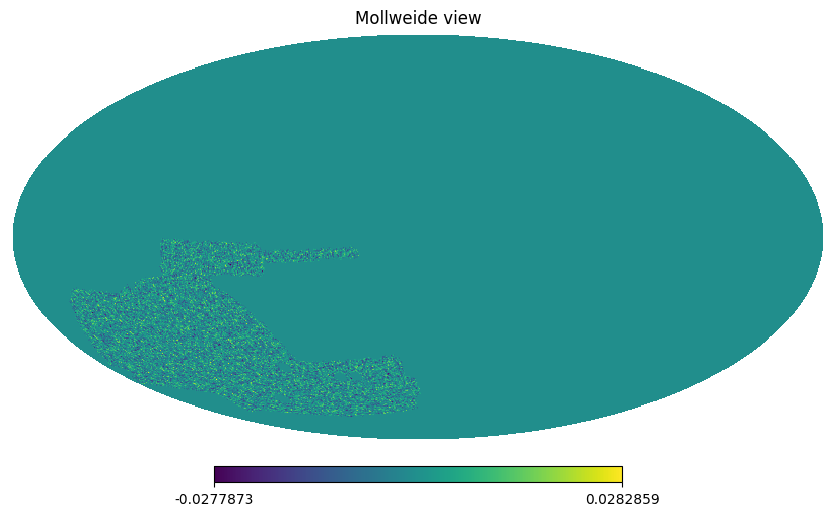

In [8]:
print(f.shape)
hp.mollview(f, nest=False)

# spherical harmonics on GPU

In [9]:
import jax
print(jax.default_backend())
print(jax.devices())

from jax.config import config
config.update("jax_enable_x64", True)
import s2fft

gpu
[gpu(id=0)]


In [10]:
sampling = "healpix"
# l_max = 2 * n_side
# l_max = 3 * n_side - 1
l_max = 1024

### jax

recursive

In [11]:
%%time
flm = s2fft.forward_jax(f, reality=True, L=l_max, sampling=sampling, nside=n_side)

CPU times: user 1min 39s, sys: 32.7 s, total: 2min 12s
Wall time: 1min 13s


In [12]:
%%time
f_recov = s2fft.inverse_jax(flm, reality=True, L=l_max, sampling=sampling, nside=n_side)
print(f"Mean absolute error = {np.nanmean(np.abs(np.real(f_recov) - f))}")

2023-10-17 08:25:32.730105: E external/xla/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_inverse_jax] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2023-10-17 08:26:19.494022: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 2m46.763676013s

********************************
[Compiling module jit_inverse_jax] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2023-10-17 08:26:19.740173: E external/xla/xla/pjrt/pjrt_stream_executor_client.cc:2461] Execution of replica 0 failed: INTERNAL: Failed to load in-memory CUBIN (compiled for a different GPU?).: CUDA_ERROR_OUT_OF_MEMORY: out of memory


XlaRuntimeError: INTERNAL: Failed to load in-memory CUBIN (compiled for a different GPU?).: CUDA_ERROR_OUT_OF_MEMORY: out of memory

precomputed

In [13]:
# %%time
# forward_precomps = s2fft.generate_precomputes_jax(L=l_max, sampling=sampling, nside=n_side, forward=True)
# inverse_precomps = s2fft.generate_precomputes_jax(L=l_max, sampling=sampling, nside=n_side, forward=False)

In [14]:
# for forward, inverse in zip(forward_precomps, inverse_precomps):
#     print(forward == inverse)

In [15]:
# total_size = 0
# for forward_precomp in forward_precomps:
#     print(type(forward_precomp))
#     print(forward_precomp.size)
#     print(forward_precomp.dtype, "\n")
    
#     total_size += forward_precomp.size
    
# print(total_size*64, "bits")

In [16]:
# total_size = 0
# for inverse_precomp in inverse_precomps:
#     print(type(inverse_precomp))
#     print(inverse_precomp.size)
#     print(inverse_precomp.dtype, "\n")
    
#     total_size += inverse_precomp.size
    
# print(total_size*64, "bits")

In [17]:
# %%time
# flm = s2fft.forward_jax(f, reality=True, L=l_max, sampling=sampling, nside=n_side, precomps=forward_precomps)

In [18]:
# %%time
# f_recov = s2fft.inverse_jax(flm, reality=True, L=l_max, sampling=sampling, nside=n_side, precomps=inverse_precomps)
# print(f"Mean absolute error = {np.nanmean(np.abs(np.real(f_recov) - f))}")

In [19]:
# %%time
# flm = s2fft.forward_jax(f, reality=True, L=l_max, sampling=sampling, nside=n_side, precomps=forward_precomps, spmd=True)

In [20]:
# %%time
# f_recov = s2fft.inverse_jax(flm, reality=True, L=l_max, sampling=sampling, nside=n_side, precomps=inverse_precomps, spmd=True)
# print(f"Mean absolute error = {np.nanmean(np.abs(np.real(f_recov) - f))}")

### numpy

In [21]:
# %%time
# flm = s2fft.forward_numpy(f, reality=True, L=l_max, sampling=sampling, nside=n_side)
# f_recov = s2fft.inverse_numpy(flm, reality=True, L=l_max, sampling=sampling, nside=n_side)
# print(f"Mean absolute error = {np.nanmean(np.abs(np.real(f_recov) - f))}")

In [22]:
# # has to be at least twice nside
# l_max = 256
# # l_max = 3 * nside - 1

# flm = s2fft.forward(f, reality=True, method=method, L=l_max, sampling=sampling, nside=nside)
# f_recov = s2fft.inverse(flm, reality=True, method=method, L=l_max, sampling=sampling, nside=nside)

# print(f"Mean absolute error = {np.nanmean(np.abs(np.real(f_recov) - f))}")

In [23]:
# l_max = 3 * 128 - 1
# method = "numpy"
# sampling = "healpix"
# nside = 128

# flm = s2fft.forward(f, reality=True, method=method, L=l_max, sampling=sampling, nside=nside)
# f_recov = s2fft.inverse(flm, reality=True, method=method, L=l_max, sampling=sampling, nside=nside)

# print(f"Mean absolute error = {np.nanmean(np.abs(np.real(f_recov) - f))}")

In [24]:
# flm = s2fft.forward_jax(example_map, reality=True, L=2000, sampling="healpix", nside=512)

In [25]:
# l_max = 100
# spin = 0
# sampling = "healpix"
# reality = True
# spmd = True

# flm = s2fft.forward(example_map, L=l_max, sampling=sampling, nside=n_side)

# # flm = s2fft.forward(example_map, reality=reality, method="jax", spmd=spmd, L=L, sampling=sampling, nside=n_side)
# # f_recov = s2fft.inverse_jax(flm, L, reality=reality, method="jax", spmd=True)

# # print(f"Mean absolute error = {np.nanmean(np.abs(np.real(f_recov) - f))}")